In [34]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

### Chargement des données

In [ ]:
train_data = pd.read_csv('data/x_train.csv')  
y_data = pd.read_csv('data/y_train.csv')
test_data = pd.read_csv('data/x_test.csv')

## Data Preparation

In [42]:
# Suppression de la colonne 'ID' (pas utile pour l'entraînement)
X = train_data.drop(columns=['ID'])
y = y_data.drop(columns=['ID'])

# Diviser les données en ensemble d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

## Modele

In [24]:
def custom_weighted_rmse(y_true, y_pred):
    weights = np.where(y_true < 0.5, 1, 1.2)
    error_per_class = weights * (y_true - y_pred) ** 2
    mean_error = np.mean(error_per_class)
    return np.sqrt(mean_error)

In [25]:
custom_scorer = make_scorer(custom_weighted_rmse, greater_is_better=False)

### Random Forest

In [43]:
model_rf = RandomForestRegressor(n_estimators=5, max_depth=7, min_samples_split=0.01, min_samples_leaf=30, random_state=42)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_val)
rmse = custom_weighted_rmse(y_val, y_pred)
print(f"Erreur quadratique moyenne pondérée (RMSE) sur les données de validation : {rmse}")

Erreur quadratique moyenne pondérée (RMSE) sur les données de validation : 0.12133482354711575


#### Cross Validation

In [44]:
# Effectuer une validation croisée à 5 folds
cv_scores = cross_val_score(model_rf, X_train, y_train, cv=5, scoring=custom_scorer)
print(f"Scores de validation croisée : {cv_scores}")
print(f"Score moyen de validation croisée : {np.mean(cv_scores)}")

Scores de validation croisée : [-0.12262503 -0.12290596 -0.12212431 -0.12119301 -0.12270612]
Score moyen de validation croisée : -0.12231088556779049


#### Grid Search

In [45]:
# 5. Optimisation des hyperparamètres avec GridSearchCV
param_grid = {
    'n_estimators': [5, 10, 20],
    'max_depth': [7, 10, 15],
    'min_samples_split': [0.01, 0.05, 0.1],
    'min_samples_leaf': [30, 50, 70]
}
# param_grid = {
#     'n_estimators': [11,12,13],
#     'max_depth': [15,20],
#     'min_samples_split': [0.01],
#     'min_samples_leaf': [30]
# }
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, scoring=custom_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")

# 6. Entraîner le modèle optimisé
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

KeyboardInterrupt: 

In [41]:
# Évaluation finale sur les données de validation
y_pred = best_model.predict(X_val)
rmse = custom_weighted_rmse(y_val, y_pred)
print(f"Erreur quadratique moyenne pondérée (RMSE) sur les données de validation : {rmse}")

Erreur quadratique moyenne pondérée (RMSE) sur les données de validation : 0.09115404934287714


### Boosting

In [13]:
model_boosting  = XGBRegressor(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=42)
model_boosting.fit(X_train, y_train)
y_pred = model_boosting.predict(X_val)
rmse = custom_weighted_rmse(y_val, y_pred)
print(f"Erreur quadratique moyenne pondérée (RMSE) sur les données de validation : {rmse}")

Erreur quadratique moyenne pondérée (RMSE) sur les données de validation : 0.025940014444500236


### Linear Regression

In [28]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# print("lr.coef_: {}".format(model_lr.coef_))
# print("lr.intercept_: {}".format(model_lr.intercept_))
y_pred_lr = model_lr.predict(X_val)
rmse_lr = custom_weighted_rmse(y_val, y_pred_lr)
print(f"Erreur quadratique moyenne pondérée (RMSE) sur les données de validation : {rmse_lr}")

Erreur quadratique moyenne pondérée (RMSE) sur les données de validation : 0.17830360502760748


### Ridge

In [31]:
model_ridge = Ridge()
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_val)
rmse_ridge = custom_weighted_rmse(y_val, y_pred_ridge)
print(f"Erreur quadratique moyenne pondérée (RMSE) sur les données de validation : {rmse_ridge}")

Erreur quadratique moyenne pondérée (RMSE) sur les données de validation : 0.17830844199981324


In [36]:
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
ridge01 = Ridge(alpha=0.1).fit(X_train, y_train)
y_pred_ridge = ridge10.predict(X_val)
rmse_ridge = custom_weighted_rmse(y_val, y_pred_ridge)
print(f"Erreur quadratique moyenne pondérée (RMSE) sur les données de validation : {rmse_ridge}")

Erreur quadratique moyenne pondérée (RMSE) sur les données de validation : 0.17838555353342755


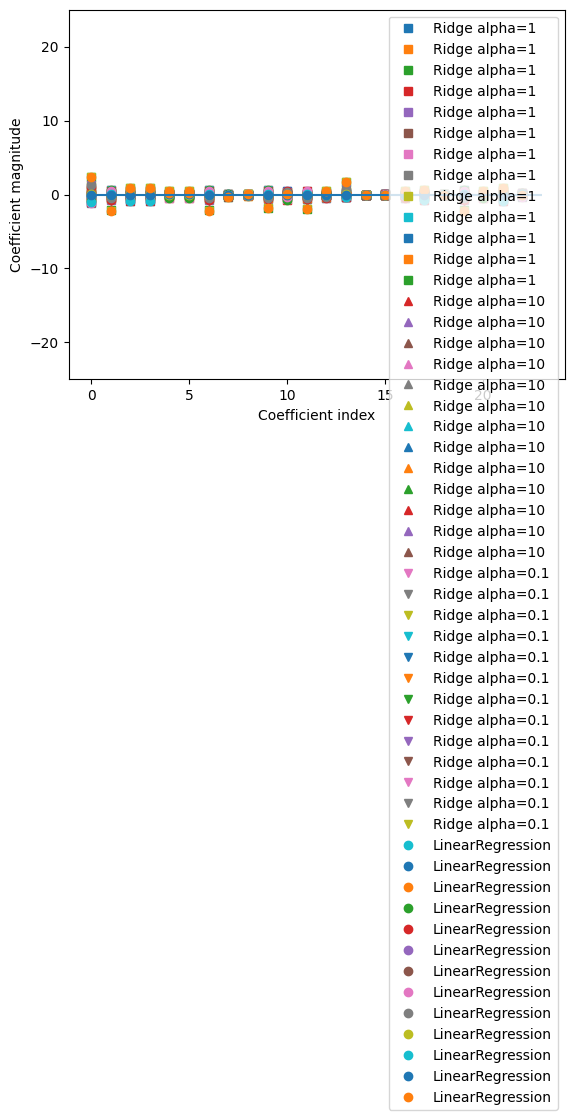

In [38]:
plt.plot(model_ridge.coef_, 's', label="Ridge alpha=1")
plt.plot(ridge10.coef_, '^', label="Ridge alpha=10")
plt.plot(ridge01.coef_, 'v', label="Ridge alpha=0.1")
plt.plot(model_lr.coef_, 'o', label="LinearRegression")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.hlines(0, 0, len(model_lr.coef_))
plt.ylim(-25, 25)
plt.legend()

### Lasso

## Test Pred

#### Test Boosting

In [20]:
# 6. Prédictions finales (sur test_data, si disponible)
test_pred = best_model.predict(test_data.drop(columns=['ID']))

In [21]:
# Enregistrement des résultats

output = pd.DataFrame(test_pred, columns=[f'c{i}' for i in range(1, 24)])
# Ajouter la colonne "ID" au début
output.insert(0, 'ID', test_data['ID'])
output.to_csv('predictions_grid_search.csv', index=False)